## Notes: the Zarr stores used are subsets of the actual big ones that we have for experimental purposes.

#### The subsets contain aggregated data of multiple NetCDF files into Zarr, which is good enough to demonstrate how a Zarr store's region can be updated.

#### `After` cells should be executed only after Prefect flows finished

Python imports

In [1]:
from datetime import datetime
import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_zarr_store(store_path: str) -> fsspec.FSMap:
    mapper = fsspec.get_mapper(store_path, check=False)
    return mapper

def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    """Convert numpy datetime64 to datetime"""
    dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# SST

In [12]:
%time

sst_store_path = 's3://imos-data-lab-optimised/4428/sst/'
sst_store = get_zarr_store(sst_store_path)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


### Write empty chunks

Before

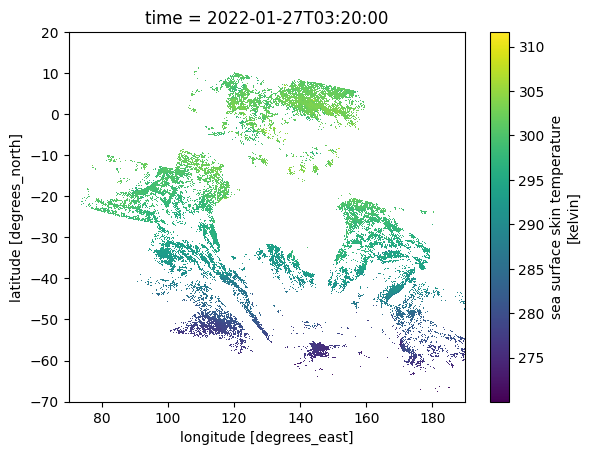

In [13]:
sst_ds = xr.open_zarr(sst_store)
sst_region_index = 26
sst_ds.isel(time=sst_region_index).sea_surface_temperature.plot()

Prefect logs:

![](https://i2.paste.pics/d3131f049be61834c78c63bcd75c5db0.png)

After

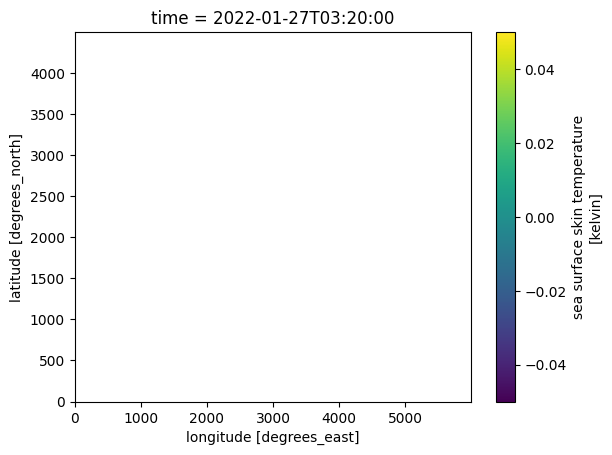

In [14]:
updated_sst_ds = xr.open_zarr(sst_store)
sst_region_index = 26
updated_sst_ds.isel(time=sst_region_index).sea_surface_temperature.plot()

### Write revised data

#### Before

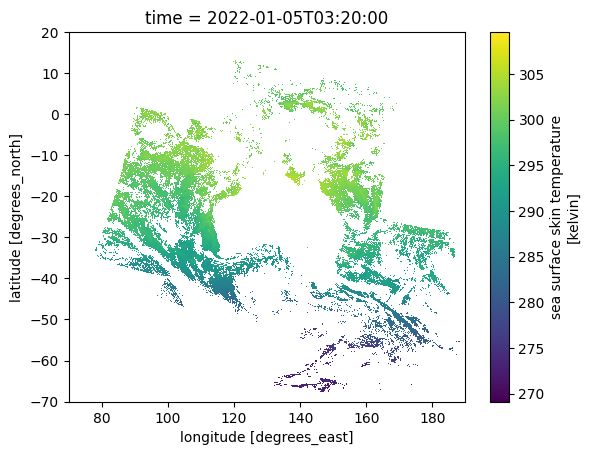

In [17]:
sst_ds_2 = xr.open_zarr(sst_store)
sst_region_index = 4
sst_ds_2.isel(time=sst_region_index).sea_surface_temperature.plot()

Prefect logs:

![](https://i2.paste.pics/abbbfeabb8568d2f57ced4dffb21e981.png)

Used `nco` to change the NetCDF file values: http://research.jisao.washington.edu/data_sets/nco/

- Download the original file:

```shell
vhnguyen@IMOS:~$ aws s3 cp s3://imos-data/IMOS/SRS/SST/ghrsst/L3S-1d/day/2022/20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc ./20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc --copy-props none

```

- Double the sea_surface_temperature values and export to new NetCDF file:

```shell
vhnguyen@IMOS:~$ ncap2 -s 'sea_surface_temperature=sea_surface_temperature*2' 20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc 20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
```

- Upload revised file to raw bucket:

```shell
vhnguyen@IMOS:~$ aws s3 cp ./20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc s3://update-zarr-region-raw/IMOS/SRS/SST/ghrsst/L3S-1d/day/2022/20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc --copy-props none
```

#### After (doubled sea_surface_temperature values: notice the **axis values**)

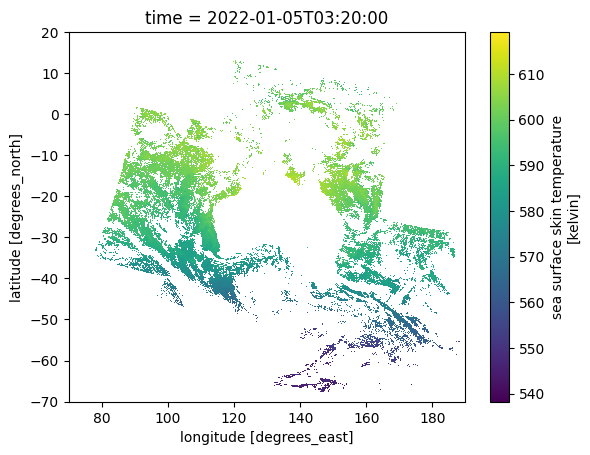

In [18]:
updated_sst_ds_2 = xr.open_zarr(sst_store)
sst_region_index = 4
updated_sst_ds_2.isel(time=sst_region_index).sea_surface_temperature.plot()

### Append new data

#### Before: Look at `time`: `{'time': (10, 10, 9)}`

There are 29 files ingested and aggregated to the Zarr store. 

Zarr store chunk's shape is `(10, 1000, 1000)`, but this pipeline processes 1 file per call, shape is `(1, 1000, 1000)`.

If 5 more files appended (34 in total), `time` would be `{'time': (10, 10, 10, 4)}`

In [23]:
sst_ds = xr.open_zarr(sst_store)
sst_ds.chunks

Frozen({'time': (10, 10, 9), 'lat': (1000, 1000, 1000, 1000, 500), 'lon': (1000, 1000, 1000, 1000, 1000, 1000)})

Upload new file that hasn't been ingested to current Zarr store

```shell
vhnguyen@IMOS:~$ aws s3 cp s3://imos-data/IMOS/SRS/SST/ghrsst/L3S-1d/day/2022/20220130032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc s3://update-zarr-region-raw/IMOS/SRS/SST/ghrsst/L3S-1d/day/2022/20220130032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc --copy-props none
```

(Note: after executing this command, the file is ingested to the Zarr store)

Prefect logs:

![](https://i2.paste.pics/80e149a2df6536f03089c77ac7c14eb1.png)

#### After: `time` is now be `{'time': (10, 10, 10)}`

In [24]:
updated_sst_ds_3 = xr.open_zarr(sst_store)
updated_sst_ds_3.chunks

Frozen({'time': (10, 10, 10), 'lat': (1000, 1000, 1000, 1000, 500), 'lon': (1000, 1000, 1000, 1000, 1000, 1000)})

# Argo

In [1]:
import s3fs
import xarray as xr
s3_store_path = 's3://imos-data-lab-optimised/4428/argo'
s3 = s3fs.S3FileSystem(anon=False)
s3_store = s3fs.S3Map(root=f'{s3_store_path}', s3=s3, check=False)
data = xr.open_zarr(s3_store)
data

<xarray.Dataset>
Dimensions:                   (N_PROF: 346, N_LEVELS: 3000)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/40)
    CONFIG_MISSION_NUMBER     (N_PROF) float32 dask.array<chunksize=(346,), meta=np.ndarray>
    CYCLE_NUMBER              (N_PROF) float32 dask.array<chunksize=(346,), meta=np.ndarray>
    DATA_CENTRE               (N_PROF) <U2 dask.array<chunksize=(346,), meta=np.ndarray>
    DATA_MODE                 (N_PROF) <U1 dask.array<chunksize=(346,), meta=np.ndarray>
    DATA_STATE_INDICATOR      (N_PROF) <U4 dask.array<chunksize=(346,), meta=np.ndarray>
    DC_REFERENCE              (N_PROF) <U32 dask.array<chunksize=(346,), meta=np.ndarray>
    ...                        ...
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 dask.array<chunksize=(346, 800), meta=np.ndarray>
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 dask.array<chunksize=(346, 800), meta=np.ndarray>
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(346, 800), meta=np.ndarray>
    TEMP_QC                   (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(346, 800), meta=np.ndarray>
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 dask.array<chunksize=(346,), meta=np.ndarray>
    WMO_INST_TYPE             (N_PROF) <U4 dask.array<chunksize=(346,), meta=np.ndarray>

In [33]:
# Quick Timeseries Profile plot of Temperature
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    if not pd.isnull(in_datetime):
        """Convert numpy datetime64 to datetime"""
        dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
        return dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    else:
        return None

### Write empty chunks

Before

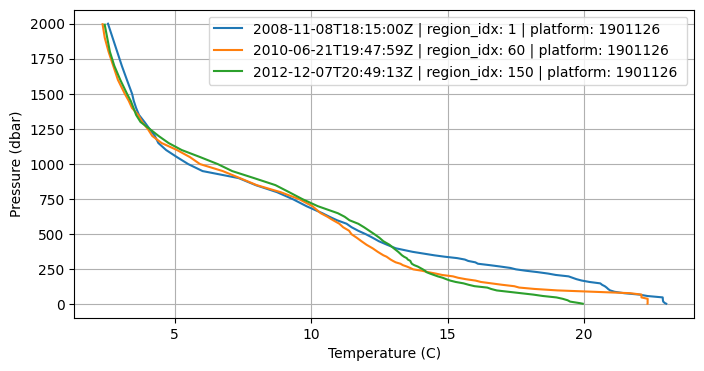

In [4]:
region_idx_1 = 1
region_idx_2 = 60
region_idx_3 = 150

fig, (ax1) = plt.subplots(1, sharey=True, figsize=(8,4))
ax1.plot(data.TEMP_ADJUSTED[region_idx_1], data.PRES_ADJUSTED[region_idx_1], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_1].values)} | region_idx: {region_idx_1} | platform: {data.PLATFORM_NUMBER[region_idx_1].values}")
ax1.plot(data.TEMP_ADJUSTED[region_idx_2], data.PRES_ADJUSTED[region_idx_2], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_2].values)} | region_idx: {region_idx_2} | platform: {data.PLATFORM_NUMBER[region_idx_2].values}")
ax1.plot(data.TEMP_ADJUSTED[region_idx_3], data.PRES_ADJUSTED[region_idx_3], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_3].values)} | region_idx: {region_idx_3} | platform: {data.PLATFORM_NUMBER[region_idx_3].values}")
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (C)')
# ax1.invert_yaxis()
ax1.legend()
# Add some gridlines
ax1.grid()
plt.show()

After removing data at region with index 1

Prefect logs:

![](https://i2.paste.pics/3b816d69d957998f1d1cad2e39674a71.png)

---

![](https://i2.paste.pics/d04c570ee28c801a908db71157af9432.png)

Blue line disappeared

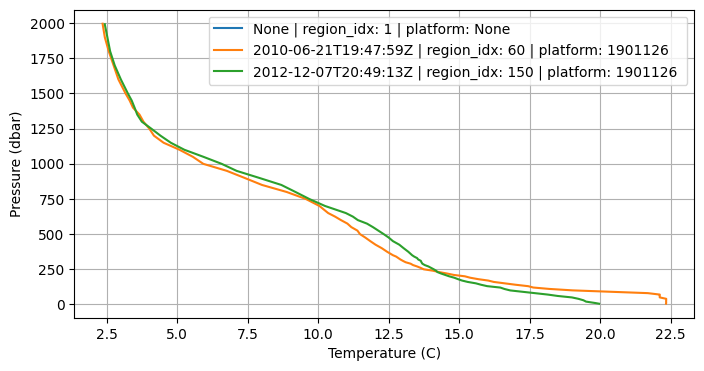

In [34]:
region_idx_1 = 1
region_idx_2 = 60
region_idx_3 = 150

fig, (ax1) = plt.subplots(1, sharey=True, figsize=(8,4))
ax1.plot(data.TEMP_ADJUSTED[region_idx_1], data.PRES_ADJUSTED[region_idx_1], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_1].values)} | region_idx: {region_idx_1} | platform: {data.PLATFORM_NUMBER[region_idx_1].values}")
ax1.plot(data.TEMP_ADJUSTED[region_idx_2], data.PRES_ADJUSTED[region_idx_2], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_2].values)} | region_idx: {region_idx_2} | platform: {data.PLATFORM_NUMBER[region_idx_2].values}")
ax1.plot(data.TEMP_ADJUSTED[region_idx_3], data.PRES_ADJUSTED[region_idx_3], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_3].values)} | region_idx: {region_idx_3} | platform: {data.PLATFORM_NUMBER[region_idx_3].values}")
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (C)')
# ax1.invert_yaxis()
ax1.legend()
# Add some gridlines
ax1.grid()
plt.show()

### Write revised data

Before

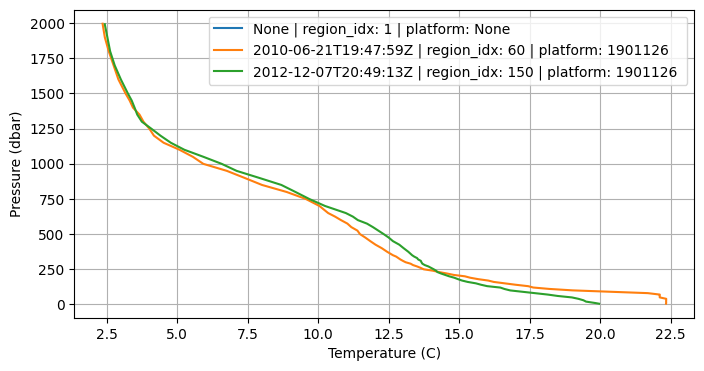

In [39]:
region_idx_1 = 1
region_idx_2 = 60
region_idx_3 = 150
data = xr.open_zarr(s3_store_path)

fig, (ax1) = plt.subplots(1, sharey=True, figsize=(8,4))
ax1.plot(data.TEMP_ADJUSTED[region_idx_1], data.PRES_ADJUSTED[region_idx_1], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_1].values)} | region_idx: {region_idx_1} | platform: {data.PLATFORM_NUMBER[region_idx_1].values}")
ax1.plot(data.TEMP_ADJaUSTED[region_idx_2], data.PRES_ADJUSTED[region_idx_2], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_2].values)} | region_idx: {region_idx_2} | platform: {data.PLATFORM_NUMBER[region_idx_2].values}")
ax1.plot(data.TEMP_ADJUSTED[region_idx_3], data.PRES_ADJUSTED[region_idx_3], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_3].values)} | region_idx: {region_idx_3} | platform: {data.PLATFORM_NUMBER[region_idx_3].values}")
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (C)')
# ax1.invert_yaxis()
ax1.legend()
# Add some gridlines
ax1.grid()
plt.show()

After

Modified pressure values of region at index 60 where temperature less than 12degree:

```shell
vhnguyen@IMOS:~$ ncap2 -s 'where(TEMP_ADJUSTED<12) PRES_ADJUSTED=PRES_ADJUSTED*0.7' D1901126_061.nc D1901126_061.nc  
```

then upload back to S3:

```shell
vhnguyen@IMOS:~$ aws s3 cp ./D1901126_061.nc s3://update-zarr-region-raw/IMOS/Argo/dac/csiro/1901126/profiles/D1901126_061.nc --copy-prop none
```

Prefect logs:

![](https://i2.paste.pics/9a5aa7cccca4d0c09881d7d0f76a8004.png)

---

![](https://i2.paste.pics/1f70ca2ee83861e3501b440c04226ded.png)


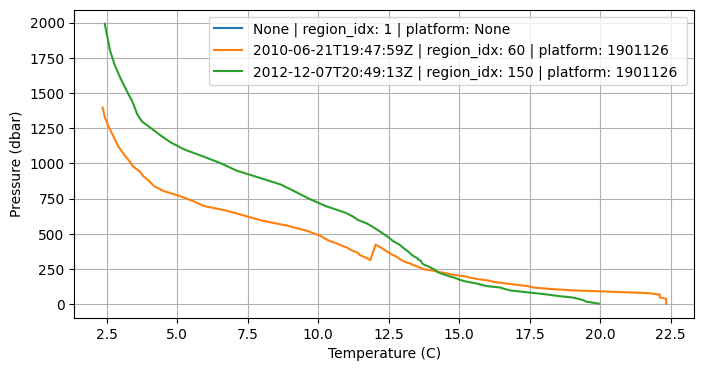

In [61]:
region_idx_1 = 1
region_idx_2 = 60
region_idx_3 = 150

fig, (ax1) = plt.subplots(1, sharey=True, figsize=(8,4))
ax1.plot(data.TEMP_ADJUSTED[region_idx_1], data.PRES_ADJUSTED[region_idx_1], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_1].values)} | region_idx: {region_idx_1} | platform: {data.PLATFORM_NUMBER[region_idx_1].values}")
ax1.plot(data.TEMP_ADJUSTED[region_idx_2], data.PRES_ADJUSTED[region_idx_2], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_2].values)} | region_idx: {region_idx_2} | platform: {data.PLATFORM_NUMBER[region_idx_2].values}")
ax1.plot(data.TEMP_ADJUSTED[region_idx_3], data.PRES_ADJUSTED[region_idx_3], 
             label=f"{np_dt64_to_dt(data.JULD[region_idx_3].values)} | region_idx: {region_idx_3} | platform: {data.PLATFORM_NUMBER[region_idx_3].values}")
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (C)')
# ax1.invert_yaxis()
ax1.legend()
# Add some gridlines
ax1.grid()
plt.show()

### Append new data

Before

In [62]:
argo_ds = xr.open_zarr(s3_store_path)
argo_ds.chunks

Frozen({'N_PROF': (346,), 'N_LEVELS': (800, 800, 800, 600)})

After appending 1 new file

Prefect logs:

![](https://i2.paste.pics/292b85732ecf07328d93841b0c413d0e.png)

In [64]:
updated_argo_ds = xr.open_zarr(s3_store_path)
updated_argo_ds

<xarray.Dataset>
Dimensions:                   (N_PROF: 347, N_LEVELS: 3000)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/40)
    CONFIG_MISSION_NUMBER     (N_PROF) float32 dask.array<chunksize=(346,), meta=np.ndarray>
    CYCLE_NUMBER              (N_PROF) float32 dask.array<chunksize=(346,), meta=np.ndarray>
    DATA_CENTRE               (N_PROF) <U2 dask.array<chunksize=(346,), meta=np.ndarray>
    DATA_MODE                 (N_PROF) <U1 dask.array<chunksize=(346,), meta=np.ndarray>
    DATA_STATE_INDICATOR      (N_PROF) <U4 dask.array<chunksize=(346,), meta=np.ndarray>
    DC_REFERENCE              (N_PROF) <U32 dask.array<chunksize=(346,), meta=np.ndarray>
    ...                        ...
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 dask.array<chunksize=(346, 800), meta=np.ndarray>
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 dask.array<chunksize=(346, 800), meta=np.ndarray>
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(346, 800), meta=np.ndarray>
    TEMP_QC                   (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(346, 800), meta=np.ndarray>
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 dask.array<chunksize=(346,), meta=np.ndarray>
    WMO_INST_TYPE             (N_PROF) <U4 dask.array<chunksize=(346,), meta=np.ndarray>